# Spark Learning Note - MLlib
Jia Geng | gjia0214@gmail.com


<a id='directory'></a>

## Directory

- [Data Source](https://github.com/databricks/Spark-The-Definitive-Guide/tree/master/data/)
- [1. Classification Models in MLlib](#sec1)
- [2. Logistic Regression](#sec2)
- [3. Tree Based Algorithm](#sec3)
    - [3.1  Decision Tree](#sec3-1)
    - [3.2 Random Forest & Gradient-boosted Tree](#sec3-2)
- [4. Naive Bayes](#sec4)
- [5. One vs Rest Classifier](#sec5)
- [6. Evaluators for Classification and Automating Model Tuning](#sec6)

In [1]:
from pyspark.sql.session import SparkSession

spark = SparkSession.builder.appName('MLexample').getOrCreate()
spark

In [2]:
data_binary_path = '/home/jgeng/Documents/Git/SparkLearning/book_data/binary-classification' 
data_binary = spark.read.parquet(data_binary_path)

In [3]:
data_binary.cache()
data_binary.show()
data_binary.printSchema()
data_binary.count()

+-----+--------------+
|label|      features|
+-----+--------------+
|    1|[3.0,10.1,3.0]|
|    0|[1.0,0.1,-1.0]|
|    0|[1.0,0.1,-1.0]|
|    1| [2.0,1.1,1.0]|
|    1| [2.0,1.1,1.0]|
+-----+--------------+

root
 |-- label: integer (nullable = true)
 |-- features: vector (nullable = true)



5

## 1. Classification Models in MLlib <a id='sec1'></a>

Spark supports following classificatoin algorithms
- Logistic Regression
- Decision Trees
- Random Forest
- Gradient-boosted Trees
- Naive Bayes

**Spark does not support Multi-label predictions natively**. Inorder to train multilabel model, one must train one model per label. (e.g. predict book's genre and book's author, you need to build two models seperately). 
- *Personal opinion: this makes assumption that different labels is independent each other. One way out is to combine these labels togther, e.g., genre, author -> genreauthor.*

[back to top](#directory)

## 2. Logistic Regression <a id='sec2'></a>

**Hyperparams**

|Name|Input|Notes|
|-|-|-|
|family|'auto'. 'binomial', 'multinomial'|specify binary/multinomial classification|
|elasticNetParam|[0, 1]|0 for l2 loss, 1 for l1 loss, (0, 1) for elastic net
|fitIntercept|True, False|whether fit intercept
|regParam|[0, inf)|0 for no regularization|
|standizatoin|True, False|whether standardize input|

**Training Params**

|Name|Input|Notes|
|-|-|-|
|maxIter|int|max iter for the optimization, default 100|
|tol|small num|stop training when changes on weight smaller than this, default 1e-6|
|weightCol|str|specify a column with the column name as the weights for the row data|

**Prediction Params**

|Name|Input|Notes|
|-|-|-|
|threshold|[0, 1]|threshold for make prediction on a class|
|thresholds|[...] sum to 1|specify an array of thresholds for each class when doing multiclass classification|

**Useful Functions & Attibutes**

|Name|Host|Notes|
|-|-|-|
|`.explainParams()`|`LogisticRegression`|print out all supported paramters|
|`.coefficients`, `.intercept`|`LogisticRegressionModel`|coef and intercept for binary logit model|
|`.coefficientMatrix`, `.interceptVector`|`LogisticRegressionModel`|coef and intercept for multinomial logit model|
|`.summary`|`LogisticRegressionModel`|attribute to get the summary of the model & performance|

**Under `model.summary`**

|Name|Type|Notes|
|-|-|-|
|`.areaUnderROC`|float|AUC metric|
|`.roc`|DataFrame|roc table: FPR vs TPR|
|`.pr`|DataFrame|precision vs recall table|
|`.objectiveHistory`|DataFrame|history of the objective function during the training process|

[back to top](#directory)

In [4]:
from pyspark.ml.classification import LogisticRegression

In [5]:
data_binary.show(1)

+-----+--------------+
|label|      features|
+-----+--------------+
|    1|[3.0,10.1,3.0]|
+-----+--------------+
only showing top 1 row



In [6]:
logit = LogisticRegression(elasticNetParam=0, regParam=1e-3).setFeaturesCol('features')\
                                                            .setLabelCol('label')  
clf = logit.fit(data_binary)

In [7]:
clf.coefficientMatrix

DenseMatrix(1, 3, [4.702, 0.1799, 2.351], 1)

In [8]:
clf.interceptVector

DenseVector([-7.1609])

In [9]:
clf.summary.roc.show()
clf.summary.pr.show()
clf.summary.areaUnderROC

+---+------------------+
|FPR|               TPR|
+---+------------------+
|0.0|               0.0|
|0.0|0.3333333333333333|
|0.0|               1.0|
|1.0|               1.0|
|1.0|               1.0|
+---+------------------+

+------------------+---------+
|            recall|precision|
+------------------+---------+
|               0.0|      1.0|
|0.3333333333333333|      1.0|
|               1.0|      1.0|
|               1.0|      0.6|
+------------------+---------+



1.0

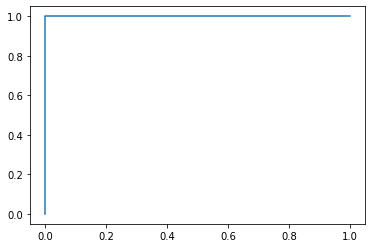

In [10]:
import matplotlib.pyplot as plt

roc_pdf = clf.summary.roc.toPandas()
plt.plot(roc_pdf['FPR'], roc_pdf['TPR'])


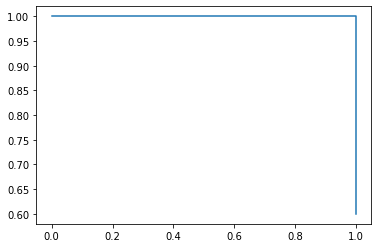

In [11]:
import matplotlib.pyplot as plt

pr_pdf = clf.summary.pr.toPandas()
plt.plot(pr_pdf['recall'], pr_pdf['precision'])

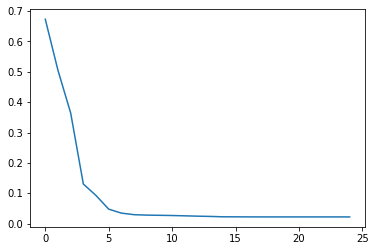

In [12]:
import matplotlib.pyplot as plt

plt.plot(clf.summary.objectiveHistory)

## 3. Tree Based Algorithm <a id='sec3'></a>

[back to top](#directory)

### 3.1 Decision Tree <a id='sec3-1'></a>

**Hyperparams**

|Name|Input|Notes|
|-|-|-|
|maxDepth|int|control the depth
|maxBins|int|num of bins. default 32, continous feature will be discretinize into bins
|impurity|'entropy', 'gini'|entropy might be a bit slower cause the log, performance no big diff for most of the cases
|minInfoGain|float|default is 0
|minInstancePerNode|int|default is 1


**Training Params**

|Name|Input|Notes|
|-|-|-|
|checkpointInterval|int|-1: no checkpoint; 10: save the model every 10 iterations; need to be set together with `checkpointDIr` and with `useNodeIDCache=True`

**Prediction Params**

|Name|Input|Notes|
|-|-|-|
|threshold|[0, 1]|threshold for make prediction on a class|
|thresholds|[...] sum to 1|specify an array of thresholds for each class when doing multiclass classification|

**Performance Metrics**

Decision tree does not have `summary` attibute. To get the performance metric, use the `BinaryClassificationEvaluator` under `pyspark.ml.evaluation`

[back to top](#directory)

In [13]:
from pyspark.ml.classification import DecisionTreeClassifier

# train
dt = DecisionTreeClassifier().setFeaturesCol('features').setLabelCol('label')
dtclf = dt.fit(data_binary)

In [14]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# evaluate using auc
res = dtclf.transform(data_binary)
res.show()
bce = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', 
                                    labelCol='label', 
                                    metricName='areaUnderROC')
print(bce.evaluate(res))
bce.explainParams()

+-----+--------------+-------------+-----------+----------+
|label|      features|rawPrediction|probability|prediction|
+-----+--------------+-------------+-----------+----------+
|    1|[3.0,10.1,3.0]|    [0.0,3.0]|  [0.0,1.0]|       1.0|
|    0|[1.0,0.1,-1.0]|    [2.0,0.0]|  [1.0,0.0]|       0.0|
|    0|[1.0,0.1,-1.0]|    [2.0,0.0]|  [1.0,0.0]|       0.0|
|    1| [2.0,1.1,1.0]|    [0.0,3.0]|  [0.0,1.0]|       1.0|
|    1| [2.0,1.1,1.0]|    [0.0,3.0]|  [0.0,1.0]|       1.0|
+-----+--------------+-------------+-----------+----------+

1.0


'labelCol: label column name. (default: label, current: label)\nmetricName: metric name in evaluation (areaUnderROC|areaUnderPR) (default: areaUnderROC, current: areaUnderROC)\nrawPredictionCol: raw prediction (a.k.a. confidence) column name. (default: rawPrediction, current: rawPrediction)'

### 3.2 Random Forest & Gradient-boosted Tree <a id='sec3-2'></a>

RF and GBT support all params in DT.

**RF Additional Hyperparams**

|Name|Input|Notes|
|-|-|-|
|numTrees|int|number of trees|
|featureSubsetStrategy|auto', 'all', 'sqrt', 'log2', a number 'n'|' usually use 'sqrt'|

**GBT Additional Hyperparams**

|Name|Input|Notes|
|-|-|-|
|LossType|'logistic'|currently only support 'logistic'|
|maxIter|int|number of iterations for the boosting|
|stepSize|float|i.e. learning rate, the step on each tree constructed on the residual|

[back to top](#directory)

In [15]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier().setFeaturesCol('features').setLabelCol('label')\
                            .setNumTrees(500).setMaxDepth(20).setFeatureSubsetStrategy('sqrt')
rdclf = rf.fit(data_binary)
rdclf.transform(data_binary).show(20, False)

+-----+--------------+-------------+-----------------------------------------+----------+
|label|features      |rawPrediction|probability                              |prediction|
+-----+--------------+-------------+-----------------------------------------+----------+
|1    |[3.0,10.1,3.0]|[20.0,478.0] |[0.040160642570281124,0.9598393574297188]|1.0       |
|0    |[1.0,0.1,-1.0]|[437.0,61.0] |[0.8775100401606426,0.12248995983935743] |0.0       |
|0    |[1.0,0.1,-1.0]|[437.0,61.0] |[0.8775100401606426,0.12248995983935743] |0.0       |
|1    |[2.0,1.1,1.0] |[20.0,478.0] |[0.040160642570281124,0.9598393574297188]|1.0       |
|1    |[2.0,1.1,1.0] |[20.0,478.0] |[0.040160642570281124,0.9598393574297188]|1.0       |
+-----+--------------+-------------+-----------------------------------------+----------+



In [16]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier().setFeaturesCol('features').setLabelCol('label')\
                    .setStepSize(0.1).setMaxIter(10).setMaxDepth(2)
gbtclf = gbt.fit(data_binary)
gbtclf.transform(data_binary).show(20, False)

+-----+--------------+----------------------------------------+----------------------------------------+----------+
|label|features      |rawPrediction                           |probability                             |prediction|
+-----+--------------+----------------------------------------+----------------------------------------+----------+
|1    |[3.0,10.1,3.0]|[-1.3259026792203317,1.3259026792203317]|[0.06587782434721744,0.9341221756527825]|1.0       |
|0    |[1.0,0.1,-1.0]|[1.325902679220332,-1.325902679220332]  |[0.9341221756527827,0.06587782434721734]|0.0       |
|0    |[1.0,0.1,-1.0]|[1.325902679220332,-1.325902679220332]  |[0.9341221756527827,0.06587782434721734]|0.0       |
|1    |[2.0,1.1,1.0] |[-1.325902679220332,1.325902679220332]  |[0.06587782434721742,0.9341221756527825]|1.0       |
|1    |[2.0,1.1,1.0] |[-1.325902679220332,1.325902679220332]  |[0.06587782434721742,0.9341221756527825]|1.0       |
+-----+--------------+----------------------------------------+---------

## 4. Naive Bayes <a id='sec4'></a>

**For classification, all input features must be non-negative.**

**Hyperparams**

|Name|Input|Notes|
|-|-|-|
|modelType|'bernoulli', 'mutinomial'|bernoulli for the proba of existance of an item. mutinnomial for the count of an items

**Training Param**

|Name|Input|Notes|
|-|-|-|
|smoothing|int|the regularization term introduced to the equation|

**Prediction Params**

|Name|Input|Notes|
|-|-|-|
|threshold|[0, 1]|threshold for make prediction on a class|
|thresholds|[...] sum to 1|specify an array of thresholds for each class when doing multiclass classification|

[back to top](#directory)

In [17]:
# the sample data is not compatible with the naive bayes assumption
# one solution is to treat all possible input value as categorical data and 

## 5. One vs Rest Classifier <a id='sec5'></a>

For K classes, construct K binary classifier and use the most confident classifier's result.

Workflow:
```
from pyspark.ml.classification import SomeClassifier, OneVsRest
from pyspark.ml.evaluation import MulticlassClassifiationEvaluator

# set up data, classifer params
train, test = ...
clf = ...

# build the one vs rest 
ovr = OneVsRest(classfier=clf)

# fit & test
ovrclf = ovr.fit(train)
predictions = ovrclf.transform(test)

# evaluate
evaluator = ...
metric = evaluator.evaluate(predictions)
```

[back to top](#directory)

## 6. Evaluators for Classification and Automating Model Tuning <a id='sec6'></a>

Three kinds of classification metrics
- Binary Classification Metircs
- Multinomial Classification Metrics
- Multilabel Classification Metrics

Two step for getting the metrics:
- Convert the prediction column and label column to rdds
```
out = model.transform(data).select('prediction', 'label')\
            .rdd.map(lambda x: (float(x[0]), float(x[1])))
```
- Construct Metrics Object object on the  with prediction results.

[back to top](#directory)

In [2]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics